In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

# Imports

In [ ]:

from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import set_seed
from peft import LoraConfig, get_peft_model

import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

# Setting Up Model

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
data = []
with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [ ]:
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)

In [ ]:
hyperparams = [2, 4, 16, 64, 128, 256]
validation_losses = {x: [] for x in hyperparams} # {hyperparam_value: validation_losses}
training_losses = {x: [] for x in hyperparams} # {hyperparam_value: training_losses}

# Training Model

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
    return [f"{100 * trainable_params / all_param}", f"{trainable_params}"]

numParamsInfo = {}
numParamsTrained = {}

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

for hyperparam in hyperparams:
  config = LoraConfig(
      r=hyperparam, # THIS IS THE HYPERPARAMETER
      lora_alpha=128,
      lora_dropout=0.05,
      bias="none",
      task_type="CAUSAL_LM"
  )
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  # Freezing the model
  for param in model.parameters():
    param.requires_grad = False
    if param.ndim == 1:
      param.data = param.data.to(torch.float32)

  model.gradient_checkpointing_enable()
  model.enable_input_require_grads()
  model.lm_head = CastOutputToFloat(model.lm_head)
  model = get_peft_model(model, config)
  trainer = transformers.Trainer(
      model=model,
      train_dataset=train_data,
      eval_dataset=val_data,
      args=transformers.TrainingArguments(
          per_device_train_batch_size=4,
          gradient_accumulation_steps=4,
          warmup_steps=100,
          max_steps=400,
          learning_rate=2e-4,
          fp16=True,
          logging_steps=1,
          evaluation_strategy="steps",
          eval_steps=20,
          output_dir='outputs',
          save_steps=250,
      ),
      data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
  )
  model.config.use_cache = False
  trainer.train()

  res = print_trainable_parameters(model)
  numParamsInfo[hyperparam] = res[0]
  numParamsTrained[hyperparam] = res[1]

  # populating data dictionaries
  for i, x in enumerate(trainer.state.log_history[:-1]):
    if (i+1) % 21 == 0:
      validation_losses[hyperparam].append(x["eval_loss"])
    else:
      training_losses[hyperparam].append(x["loss"])
  training_losses[hyperparam] = [sum(training_losses[hyperparam][i:i+20]) / 20 for i in range(0, len(training_losses[hyperparam]), 20)]


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.516300,4.152069
40,4.356300,4.011637
60,3.937600,3.771014
80,3.751600,3.573609
100,3.623700,3.508193
120,3.458000,3.476285
140,3.536300,3.459256
160,3.478600,3.444040
180,3.594700,3.432877
200,3.385900,3.428982


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.508600,4.147457
40,4.325500,4.000975
60,3.926700,3.760993
80,3.746200,3.579513
100,3.651700,3.509679
120,3.470900,3.478692
140,3.531000,3.456392
160,3.469000,3.443127
180,3.588400,3.431257
200,3.388200,3.429901


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 147456 || all params: 124587264 || trainable%: 0.11835559692522023


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.505900,4.145595
40,4.329800,4.001714
60,3.910600,3.753450
80,3.725700,3.569432
100,3.639000,3.502059
120,3.442900,3.472118
140,3.508900,3.450035
160,3.452400,3.436364
180,3.570600,3.426303
200,3.362300,3.424203


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 589824 || all params: 125029632 || trainable%: 0.4717473694555863


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.510600,4.147759
40,4.343000,4.009735
60,3.918000,3.756588
80,3.730500,3.566791
100,3.637300,3.501119
120,3.442300,3.469845
140,3.515700,3.449327
160,3.452800,3.435169
180,3.565500,3.422712
200,3.361600,3.421609


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 2359296 || all params: 126799104 || trainable%: 1.8606566809809635


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.508100,4.147072
40,4.336700,4.007051
60,3.914300,3.754916
80,3.728100,3.566440
100,3.639800,3.501182
120,3.440500,3.470449
140,3.518100,3.449497
160,3.452400,3.434984
180,3.569600,3.423257
200,3.364400,3.422977


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 4718592 || all params: 129158400 || trainable%: 3.653337297458005


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.506200,4.146178
40,4.336000,4.006992
60,3.913500,3.754948
80,3.725100,3.566340
100,3.634800,3.500535
120,3.441100,3.470321
140,3.514800,3.449536
160,3.455700,3.434499
180,3.569900,3.424003
200,3.362500,3.423321


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 9437184 || all params: 133876992 || trainable%: 7.049145532041831


# Testing Model

In [ ]:
set_seed(40)

device = model.device
batch = tokenizer("How did you solve the murder mystery with Watson? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How did you solve the murder mystery with Watson? ->: _____ The murder mystery with Watson was solved, after some time. I think that the explanation for his sudden disappearance would be similar to that of a thief. He was caught on a motorcycle riding through parts of the city on his bicycle. He died in the middle of the night, on his way home to his home near Houghton, Scotland. His wife was not there. There was a brief but violent argument. The man was found dead and his body was discovered in the parking lot of an


# Analyzing Results

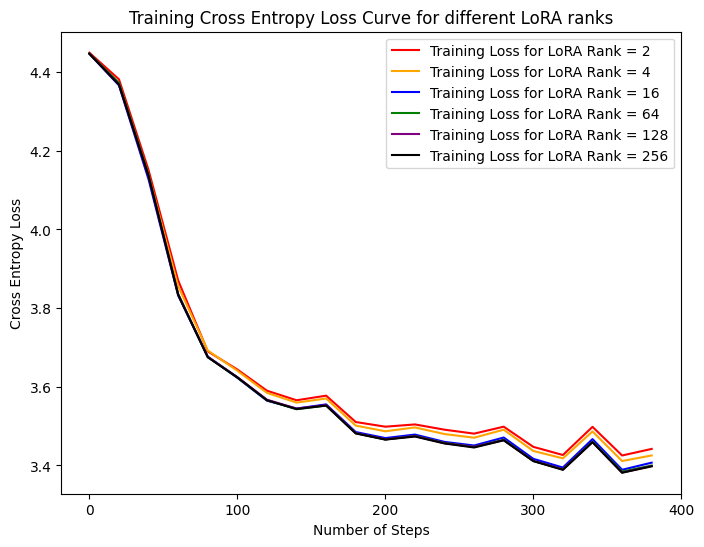

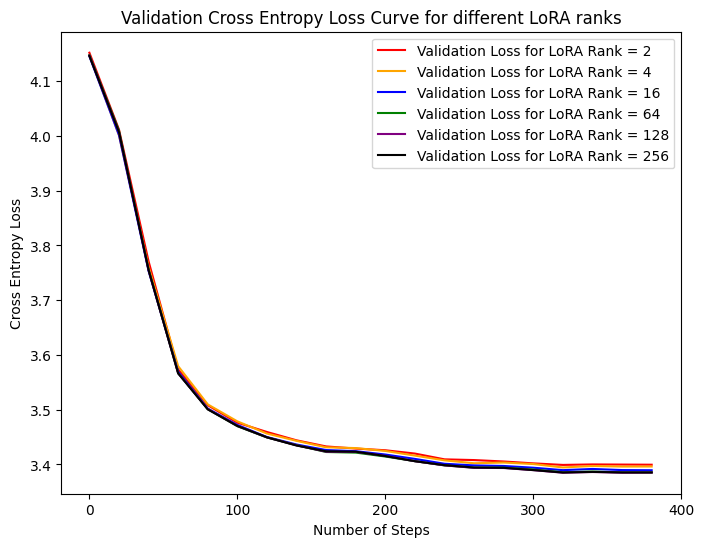

In [ ]:
colors = ["red", "orange", "blue", "green", "purple", "black"]

#Training Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(training_losses[hyperparams[i]], label=f"Training Loss for LoRA Rank = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20], [0, 100, 200, 300, 400])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve for different LoRA ranks")
plt.legend()
plt.show()


#Validation Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(validation_losses[hyperparams[i]], label=f"Validation Loss for LoRA Rank = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20], [0, 100, 200, 300, 400])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve for different LoRA ranks")
plt.legend()
plt.show()

In [ ]:
#Number of trainable parameters per model

for hyperparam in hyperparams:
  print("LoRA Rank of ", hyperparam)
  print(numParamsInfo[hyperparam]) #percentage of trainable parameters
  print(numParamsTrained[hyperparam]) #number of trainable parameters
  print("\n")


LoRA Rank of  2
0.05921283931732531
73728


LoRA Rank of  4
0.11835559692522023
147456


LoRA Rank of  16
0.4717473694555863
589824


LoRA Rank of  64
1.8606566809809635
2359296


LoRA Rank of  128
3.653337297458005
4718592


LoRA Rank of  256
7.049145532041831
9437184


